In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from  gpdc1d import *
import statsmodels.api as sm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def get_weights(num, mode):
    """
    Returns the weights of a discrete filter
    
    Keyword arguments:
    num -- number of weights to generate
    mode -- the type of generating process used
    weight_step -- the interval between the evenly sampled weights
    """
    if mode == 'uniform':
        weights = np.ones(num)
    elif mode == 'random':
        np.random.seed(123)
        weights = np.abs(np.random.randn(num))
        print(weights)
    elif mode == 'triangle':
        weights = np.ones(num)
        center = num // 2
        step = 2
        for i in range(center+1):
            weights[i] = (step*(i+1))
            weights[-(i+1)] = (step*(i+1))
    elif mode == 'dirac':
        weights = np.zeros(num)
        weights[num//2] = 1.
    else:
        print("Error: unknown mode {}".format(mode))
        return -1
    
    return weights/np.sum(weights)


In [18]:
def plot_results(my_times_x, post_mean_x, post_cov_x, post_mean_x_2, post_cov_x_2, time_obs, signal_obs,
                 times_x, x, weights, my_weights, my_weights_2, my_weight_steps, id_, kernel_name):
    fig = plt.figure(figsize=(20,5), constrained_layout=False)
    gs1 = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=.5)
    fig_ax1 = fig.add_subplot(gs1[0, :-1])
    fig_ax2 = fig.add_subplot(gs1[0, -1])
    fig_ax3 = fig.add_subplot(gs1[1, :-1])
    fig_ax4 = fig.add_subplot(gs1[1, -1])
    fig_ax5 = fig.add_subplot(gs1[-1, :-1])
    fig_ax6 = fig.add_subplot(gs1[-1, -1])
    
    
    fig_ax1.get_xaxis().set_visible(False)
    fig_ax2.get_xaxis().set_visible(False)
    fig_ax3.get_xaxis().set_visible(False)
    fig_ax4.get_xaxis().set_visible(False)


    fig_ax1.plot(times_x, x, label='x', color='cornflowerblue')
    fig_ax1.scatter(time_obs, signal_obs, marker='o', color='indianred', label='observations')
    fig_ax1.plot([],[], color='green', label='GPDC')
    fig_ax1.set_xlim([0,5])
    fig_ax1.set_ylim([-3,3])
    fig_ax1.legend(loc="upper right", ncol=3, bbox_to_anchor=(1.1, 1.6))
    
    fig_ax2.plot([my_gpc.offset + i*0.01 for i in range(len(weights)) ], weights, label="continuous filter", color='cornflowerblue')
    fig_ax2.legend(bbox_to_anchor=(0.7, 1.1))
    
    
    error_bars = 2 * np.sqrt(np.diag(post_cov_x_2))
    fig_ax3.fill_between(my_times_x, post_mean_x_2 - error_bars, post_mean_x_2 + error_bars, color='green',alpha=0.1, label='95% error bars')
    fig_ax3.plot(my_times_x ,post_mean_x_2, label='posterior mean', color='green')
    fig_ax3.plot(times_x, x, color='cornflowerblue')
    #fig_ax2.plot(times_x, x,label='x', color='k')
    fig_ax3.set_xlim([0,5])
    #fig_ax2.set_ylim([-3,3])
    #fig_ax2.legend(loc="upper right")

    fig_ax4.scatter([my_gpc.offset +i*my_weight_steps for i in range(len(my_weights_2))], my_weights_2, marker='o', color='indianred', label="observed filter")
    #fig_ax3.set_xlim([-0.3,0.3])
    fig_ax4.legend(bbox_to_anchor=(0.7, 1.1))

    
    
    error_bars = 2 * np.sqrt(np.diag(post_cov_x))
    fig_ax5.fill_between(my_times_x, post_mean_x - error_bars, post_mean_x + error_bars, color='green',alpha=0.1, label='95% error bars')
    fig_ax5.plot(my_times_x ,post_mean_x, label='posterior mean', color='green')
    fig_ax5.plot(times_x, x, color='cornflowerblue')

    #fig_ax2.plot(times_x, x,label='x', color='k')
    fig_ax5.set_xlim([0,5])
    #fig_ax2.set_ylim([-3,3])
    #fig_ax2.legend(loc="upper right")


   
    
    fig_ax6.scatter([my_gpc.offset +i*my_weight_steps for i in range(len(my_weights))], my_weights, marker='o', color='green', label="learned filter")
    #fig_ax3.set_xlim([-0.3,0.3])
    fig_ax6.legend(bbox_to_anchor=(0.7, 1.1))

    fig_ax5.plot(times_x, x)
    fig.savefig("figures/learning_weights_{}_{}.pdf".format(kernel_name, id_), bbox_inches='tight')

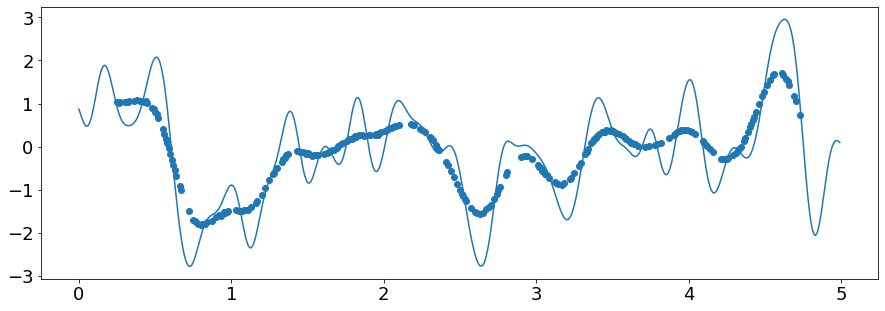

start learning model 1
Optimization terminated successfully.
         Current function value: -660.246448
         Iterations: 7
         Function evaluations: 772
Hyperparameters are:
[3.49838873e+01 3.29602592e-09 9.55015175e-03]
start learning model 2
Optimization terminated successfully.
         Current function value: -262.559216
         Iterations: 3
         Function evaluations: 107
Hyperparameters are:
[5.82055344e+01 7.74973463e-02 4.60900092e-02]


In [19]:
# experiment parameters
save = True
num_obs = 400
mode = 'triangle'
l_x = np.sqrt(0.01)
gamma_x = 1 / (2 * l_x**2)

kernels = ['rbf', 'matern', 'spectral']
kernels = ['spectral']
rdns = np.random.RandomState(123)
for kernel_name in kernels:
    np.random.seed(789)
    # generate signals
    num_weights = 51
    times_x = np.arange(0, 5, 0.01)
    if kernel_name == 'matern':
        kernel = matern(times_x, times_x, [1.1])
    elif kernel_name == 'rbf':
        kernel = rbf(times_x, times_x, [50, 1])
    elif kernel_name == 'spectral':
        kernel = Spec_Mix(times_x, times_x, [gamma_x, 1])

    x = rdns.multivariate_normal(np.zeros_like(times_x),  kernel)
    weights = get_weights(num_weights, mode)
    signal = np.convolve(weights, x, mode='valid') # use 'valid' instead
    indices = np.random.randint(0, len(signal), size=num_obs)
    indices = np.unique(indices)
    signal_obs = signal[indices] + 0.01*np.random.randn(len(indices))
    time_obs = times_x[num_weights//2:-num_weights//2+1]
    time_obs = time_obs[indices]
    #time_obs = times_x[indices]

    plt.plot(times_x, x, label='x')
    plt.scatter(time_obs, signal_obs)
    plt.show()
    print("start learning model 1")
    num_weights = 5
    weight_step = .5 / (num_weights-1)
    offset = -(num_weights//2)*weight_step
    my_gpc = gpc(time_obs, signal_obs, num_weights, weight_step, offset, kernel=kernel_name)
    my_gpc.train()
    my_gpc.compute_moments()
    print("start learning model 2")
    my_weights = get_weights(num_weights, mode)
    my_gpc2 = gpc(time_obs, signal_obs, num_weights, weight_step, offset, kernel=kernel_name, weights=my_weights)
    my_gpc2.train()
    my_gpc2.compute_moments()
    
    if save:
        np.save("computations/{}_post_mean_f".format(kernel_name), my_gpc.post_mean_f)
        np.save("computations/{}_post_mean_x".format(kernel_name), my_gpc.post_mean_x)
        np.save("computations/{}_post_cov_f".format(kernel_name), my_gpc.post_cov_f)
        np.save("computations/{}_post_cov_x".format(kernel_name), my_gpc.post_cov_x)
        np.save("computations/{}_x".format(kernel_name), x)
        np.save("computations/{}_signal".format(kernel_name), signal)
        np.save("computations/{}_times_x".format(kernel_name), my_gpc.times_x)
        np.save("computations/{}_time_obs".format(kernel_name), time_obs)
        np.save("computations/{}_signal_obs".format(kernel_name), signal_obs)
        np.save("computations/{}_weights".format(kernel_name), weights)
        np.save("computations/{}_my_weights".format(kernel_name), my_gpc.weights)
        np.save("computations/{}_my_weight_steps".format(kernel_name), my_gpc.weight_step)
        
        np.save("computations/{}_post_mean_f_2".format(kernel_name), my_gpc2.post_mean_f)
        np.save("computations/{}_post_mean_x_2".format(kernel_name), my_gpc2.post_mean_x)
        np.save("computations/{}_post_cov_f_2".format(kernel_name), my_gpc2.post_cov_f)
        np.save("computations/{}_post_cov_x_2".format(kernel_name), my_gpc2.post_cov_x)
        np.save("computations/{}_my_weights_2".format(kernel_name), my_gpc2.weights)





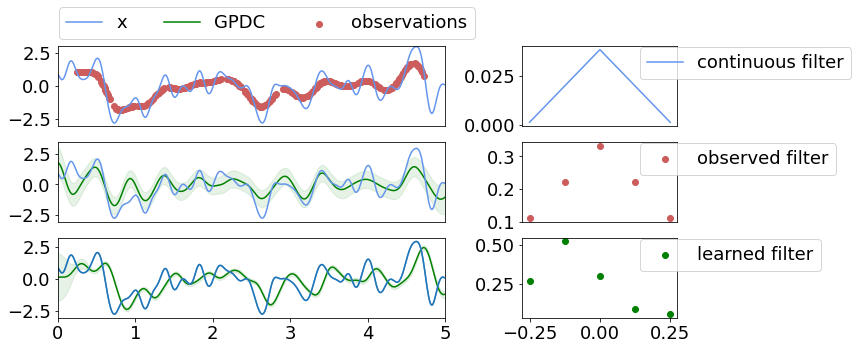

In [20]:
times_x = np.arange(0, 5, 0.01)
kernel_name = 'spectral'
post_mean_f = np.load("computations/{}_post_mean_f.npy".format(kernel_name))
post_mean_x = np.load("computations/{}_post_mean_x.npy".format(kernel_name))
post_cov_f = np.load("computations/{}_post_cov_f.npy".format(kernel_name))
post_cov_x = np.load("computations/{}_post_cov_x.npy".format(kernel_name))
x = np.load("computations/{}_x.npy".format(kernel_name))
signal = np.load("computations/{}_signal.npy".format(kernel_name))
my_times_x =np.load("computations/{}_times_x.npy".format(kernel_name))
time_obs = np.load("computations/{}_time_obs.npy".format(kernel_name))
signal_obs = np.load("computations/{}_signal_obs.npy".format(kernel_name))
weights = np.load("computations/{}_weights.npy".format(kernel_name))
my_weights = np.load("computations/{}_my_weights.npy".format(kernel_name))
my_weight_steps = np.load("computations/{}_my_weight_steps.npy".format(kernel_name))


post_mean_f_2 = np.load("computations/{}_post_mean_f_2.npy".format(kernel_name))
post_mean_x_2 = np.load("computations/{}_post_mean_x_2.npy".format(kernel_name))
post_cov_f_2 = np.load("computations/{}_post_cov_f_2.npy".format(kernel_name))
post_cov_x_2 = np.load("computations/{}_post_cov_x_2.npy".format(kernel_name))
my_weights_2 = np.load("computations/{}_my_weights_2.npy".format(kernel_name))




plot_results(my_times_x, post_mean_x, post_cov_x, post_mean_x_2/3, post_cov_x_2, time_obs, signal_obs, 
             times_x, x, weights, my_weights, my_weights_2, my_weight_steps, 0, kernel_name)